In [185]:
#!/usr/bin/env python
import sys
sys.path.append('/Users/carol/repos/emg-regression')
# print(sys.path)

import numpy as np
import matplotlib.pyplot as plt
from emg_regression.models.pendulum import Pendulum
from emg_regression.models.spherical_pendulum import SphericalPendulum
from emg_regression.utils.integrator import Integrator
from emg_regression.interfaces.my_interface import Interface
from emg_regression.utils.visualization import vis_3D_motion
import random

%matplotlib widget

In [186]:
dt = 0.01
length = 0.5
gravity = 9.81

# model
model = SphericalPendulum(length=length)

# integrator
integrator = Integrator(step=dt)

# simulate
T = 3
t = np.arange(0,T,dt)

# 2D case, initialize states

# Define system input force (control and gravity compensation)

# generate input signal randomly (control forces for theta and phi)
u_c = lambda t,a1,a2,a3,b1,b2,b3: a1 * np.sin(a2*t + a3) + b1 * np.cos(b2*t + b3)
min_val0, max_val0 = -.5, .5
min_val1, max_val1 = -.3, .3
a1, a2, a3, b1, b2, b3 = [random.uniform(min_val0, max_val0) for _ in range(6)]
c1, c2, c3, d1, d2, d3 = [random.uniform(min_val1, max_val1) for _ in range(6)]
u_theta = u_c(t,a1,a2,a3,b1,b2,b3)
u_phi   = u_c(t,c1,c2,c3,d1,d2,d3)
u_control = np.array([u_theta,u_phi]).T

# gravity compensation
u_gravity = lambda phi: np.array([0, -(gravity/length)*np.sin(phi)])

In [187]:
# Define initial conditions and integrate
t_ = dt
k  = 0

x = np.array([[0.0, 0.0, 0.0, 0.0]]) # state vec: theta, phi, theta_dot, phi_dot
u = np.array([-u_control[k] + u_gravity(x[-1][1])])
a = np.array([integrator(model, x[-1], u[-1])[1]])

ug = np.array([u_gravity(x[-1][1])])


while t_+dt < T:
    x_k = x[-1]
    u_k = -u_control[k] + u_gravity(x_k[1])
    x_, a_ = integrator(model, x_k, u_k)

    ug = np.vstack((ug, u_gravity(x_k[1])[np.newaxis,:]))
    u = np.vstack((u, u_k[np.newaxis,:]))
    x = np.vstack((x, x_[np.newaxis,:]))
    a = np.vstack((a, a_[np.newaxis,:]))

    t_ += dt
    k += 1


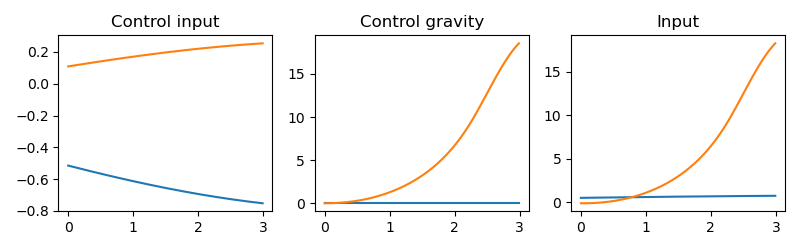

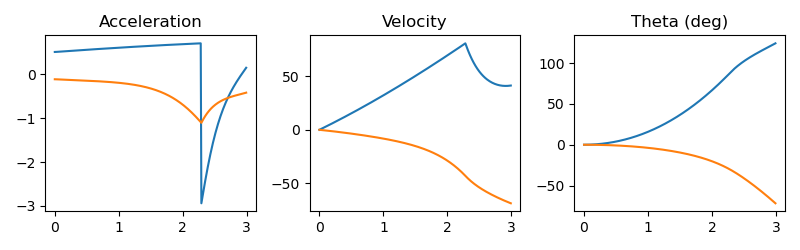

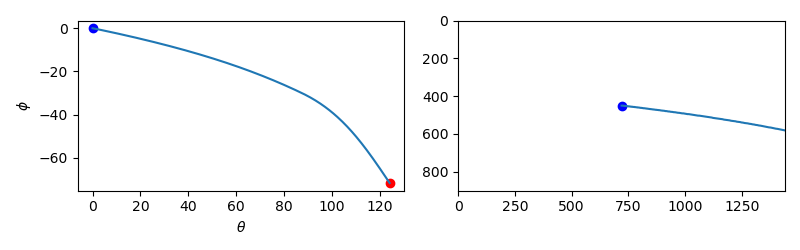

In [188]:
# Show

vis = 1
if vis:
    # Input forces
    fig = plt.figure(figsize=(8,2.5))
    ax = fig.add_subplot(131)
    ax.plot(t, u_control) # input
    ax.set_title('Control input')
    ax = fig.add_subplot(132)
    ax.plot(t, ug) # input
    ax.set_title('Control gravity')
    ax = fig.add_subplot(133)
    ax.plot(t, u) # input
    ax.set_title('Input')
    plt.tight_layout()
    plt.show()

    # System states
    fig = plt.figure(figsize=(8,2.5))
    ax = fig.add_subplot(131)
    ax.plot(t, a) # input
    ax.set_title("Acceleration")
    ax = fig.add_subplot(132)
    ax.plot(t, x[:,2:]*180/np.pi) # input
    ax.set_title("Velocity")
    ax = fig.add_subplot(133)
    ax.plot(t,  x[:,:2]*180/np.pi) # input
    ax.set_title("Theta (deg)")
    plt.tight_layout()
    plt.show()

    # Produced motion path
    # Projection on visual interface
    H_ = np.array([-np.pi/3, np.pi/3, -np.pi/3, np.pi/3])
    interface = Interface(length=length,H=H_,home_loc='center')
    p = interface(x[:,:2])
    x_deg = x*180/np.pi

    fig = plt.figure(figsize=(8,2.5))
    ax = fig.add_subplot(121)
    ax.plot(x_deg[:,0],x_deg[:,1])
    ax.scatter(x_deg[0,0] ,x_deg[0,1] ,c='blue')
    ax.scatter(x_deg[-1,0],x_deg[-1,1],c='red')
    ax.set_xlabel(r'$\theta$')
    ax.set_ylabel(r'$\phi$')

    ax = fig.add_subplot(122)
    ax.plot(p[:,0],p[:,1])
    ax.scatter(p[0,0] ,p[0,1] ,c='blue')
    ax.scatter(p[-1,0],p[-1,1],c='red')
    ax.set_xlim([0,interface.d1])
    ax.set_ylim([interface.d2,0])
    plt.tight_layout()
    plt.show()




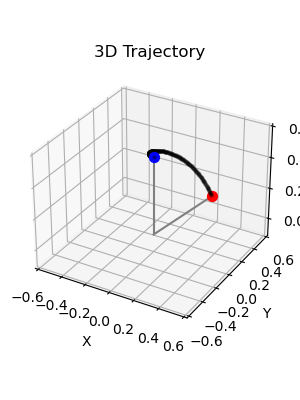

In [189]:
# 3D coordinates
theta, phi = x[:,0], x[:,1]
margin = 0.1

# Create a 3D plot
fig = plt.figure(figsize=(3,4))
ax = fig.add_subplot(111, projection='3d')

for i in range(len(x)):

    # Calculate the pendulum position in cartesian coordinates
    e1 = length * np.cos(theta[i]) * np.sin(phi[i])
    e2 = - length * np.sin (theta[i]) * np.sin(phi[i])
    e3 = length * np.cos(phi[i])

    # Plot the trajectory
    if i == 0:
        ax.scatter(e1, e2, e3,color='blue',s=50)
        ax.plot([0,e1], [0,e2], [0,e3],color='grey')
    if i == len(x)-1:
        ax.scatter(e1, e2, e3,color='red',s=50)
        ax.plot([0,e1], [0,e2], [0,e3],color='grey')
    else:
        ax.scatter(e1, e2, e3,color='k',s=5,alpha=0.3)

# Set plot limits for visualization
ax.set_xlim(-length-margin, length+margin)
ax.set_ylim(-length-margin, length+margin)
ax.set_zlim(0-margin,length+margin)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Trajectory')
# ax.legend()
plt.tight_layout()
plt.show()

